# 최종목표
- protrait 데이터로 유명한 PFCN dataset을 이용해서 사람의 영역을 추출
- 큰 사진을 작게 줄이고 오토인코더식 접근방법

In [51]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from IPython.display import Image

SEED = 34

In [52]:
pfcn_small = np.load('./pfcn_small.npz')

In [53]:
# 사람이미지, 사람 영역이 흑백으로 된 이미지
train_images = pfcn_small['train_images']
train_mattes = pfcn_small['train_mattes']
test_images = pfcn_small['test_images']
test_mattes = pfcn_small['test_mattes']

In [54]:
train_images.dtype

dtype('float64')

In [55]:
# 0이 아닌 숫자 출력
test_images[test_images!= 0][:10]
print(train_images.shape)
print(train_images.dtype)
print(train_mattes.shape)
print(test_images.shape)
print(test_images.dtype)

(1700, 100, 75, 3)
float64
(1700, 100, 75)
(300, 100, 75, 3)
float64


In [56]:
print(train_images.min(), train_images.max())

0.0 1.0


In [57]:
from skimage import color

In [58]:
train_mattes[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.]])

In [59]:
color.rgb2gray(train_mattes[0]).reshape((100,75,1))

/Users/gueunhye/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  """Entry point for launching an IPython kernel.


array([[[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       ...,

       [[0.],
        [0.],
        [0.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [1.],
        [1.],
        [1.]]])

In [88]:
# 지금은 마지막 값이 3으로 컬러인데 1로 바꾸려면 흑백로 이미지 바꿔주기
#train_mattes = np.array([color.rgb2gray(img).reshape((100,75,1)) for img in train_mattes])
test_mattes = np.array([color.rgb2gray(img).reshape((100,75,1))for img in test_mattes])

/Users/gueunhye/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  This is separate from the ipykernel package so we can avoid doing imports until


In [89]:
print(train_mattes.shape, test_mattes.shape)

(1700, 100, 75, 1) (300, 100, 75, 1)


In [62]:
from skimage import color

print(train_mattes.shape, test_mattes.shape)

(1700, 100, 75, 1) (300, 100, 75)


In [63]:
train_images[:5].shape

(5, 100, 75, 3)

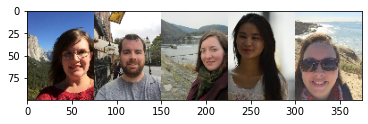

In [64]:
plt.imshow(train_images[:5].transpose([1,0,2,3]).reshape(100,-1,3))
plt.show()

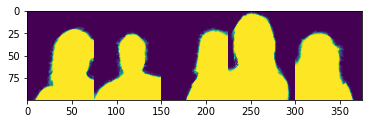

In [65]:
plt.imshow(train_mattes[:5].transpose([1,0,2,3]).reshape((100, -1)))
plt.show()

In [72]:
train_images[:5].shape

(5, 100, 75, 3)

In [67]:
# input (100, 75, 3), output (100, 75, 1)을 처리할 수 있는 모래시계 모양의 모델을 작성하세요.
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, Dense, Flatten, Reshape
from tensorflow.keras.models import Model

In [74]:
def ae_like():
    inputs = Input((100,75,3))
    x = Conv2D(32,3,2,activation = 'relu', padding = 'same')(inputs)
    x = Conv2D(64,3,2,activation = 'relu',padding = 'same')(x)
    x = Conv2D(128,3,2,activation = 'relu',padding = 'same')(x)
    x = Flatten()(x)
    latent = Dense(10)(x)
    
    x = Dense((13*10*128))(latent)
    x = Reshape((13,10,128))(x)
    
    x = UpSampling2D(size = (2,2))(x)
    x = Conv2D(128, (2,2), (1,1), activation='relu', padding='valid')(x)
    x = UpSampling2D(size = (2,2))(x)
    x = Conv2D(64, (1,1), (1,1), activation='relu', padding='valid')(x)
    x = UpSampling2D(size = (2,2))(x)
    x = Conv2D(32, (1,2), (1,1), activation='relu', padding='valid')(x)

    x = Conv2D(1, (1,1), (1,1), activation='sigmoid')(x)

    model = Model(inputs, x)
    return model

In [75]:
model = ae_like()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 75, 3)]      0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 50, 38, 32)        896       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 25, 19, 64)        18496     
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 13, 10, 128)       73856     
_________________________________________________________________
flatten_4 (Flatten)          (None, 16640)             0         
_________________________________________________________________
dense (Dense)                (None, 10)                166410    
_________________________________________________________________
dense_1 (Dense)              (None, 16640)             183040

In [76]:
model.compile(loss='mse',optimizer = 'adam', metrics = ['acc'])

In [79]:
hist = model.fit(train_images, train_mattes, validation_data= (test_images,test_mattes),epochs = 25, verbose = 1)

Train on 1700 samples, validate on 300 samples
Epoch 1/25
1700/1700 [==============================] - 145s 86ms/sample - loss: 0.1384 - acc: 0.7506 - val_loss: 0.1287 - val_acc: 0.7617
Epoch 2/25
1700/1700 [==============================] - 143s 84ms/sample - loss: 0.1265 - acc: 0.7628 - val_loss: 0.1227 - val_acc: 0.7632
Epoch 3/25
1700/1700 [==============================] - 144s 85ms/sample - loss: 0.1186 - acc: 0.7722 - val_loss: 0.1050 - val_acc: 0.7898
Epoch 4/25
1700/1700 [==============================] - 144s 85ms/sample - loss: 0.0979 - acc: 0.8019 - val_loss: 0.0910 - val_acc: 0.8085
Epoch 5/25
1700/1700 [==============================] - 146s 86ms/sample - loss: 0.0854 - acc: 0.8181 - val_loss: 0.0817 - val_acc: 0.8200
Epoch 6/25
1700/1700 [==============================] - 148s 87ms/sample - loss: 0.0793 - acc: 0.8261 - val_loss: 0.0785 - val_acc: 0.8243
Epoch 7/25
1700/1700 [==============================] - 148s 87ms/sample - loss: 0.0711 - acc: 0.8375 - val_loss: 0.075

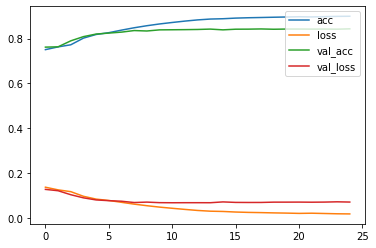

In [145]:
# hist의 accuracy plt의 plot을 이용하여 출력하는 코드를 작성하세요.
plt.plot(hist.history['acc'], label='acc')
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_acc'], label='val_acc')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.legend(loc='upper right')
plt.show()

In [81]:
# 모델에 test_mages 중 1장을 넣고 결과를 받는 코드를 작성하세요.
res = model.predict(test_images[0:1])

In [90]:
print(res[0].shape)
print(test_mattes[0].shape) # test 이미지

(100, 75, 1)
(100, 75, 1)


In [113]:
np.concatenate([res[0],test_mattes[0]]).shape

(200, 75, 1)

In [134]:
# reshape -> transpose -> reshape
# 이미지수, height, width, channel
np.concatenate([res[0],test_mattes[0]]).reshape(2,-1,75,1).shape

(2, 100, 75, 1)

In [137]:
# 행,열 값 바꾸기 (전치행렬?)
np.concatenate([res[0],test_mattes[0]]).reshape(2,-1,75,1).transpose([1,0,2,3]).shape

(100, 2, 75, 1)

In [139]:
# reshape (100, 2*75) -> 두개의 이미지를 하나로 만들어주는 느낌
np.concatenate([res[0],test_mattes[0]]).reshape(2,-1,75,1).transpose([1,0,2,3]).reshape((100,-1)).shape

(100, 150)

In [117]:
# 이미지 수, height, width, channel
np.concatenate([res[0],test_mattes[0]]).reshape(2,-1,75, 1).transpose([0,1,2,3]).shape

(2, 100, 75, 1)

In [120]:
# 이미지 수, height, width, channel
np.concatenate([res[0],test_mattes[0]]).reshape(2,-1,75, 1).transpose([1,0,2,3]).reshape((100,-1)).shape

(100, 150)

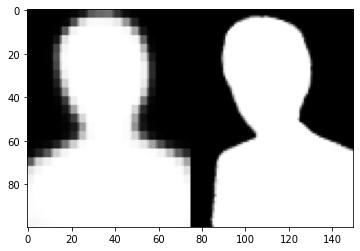

In [91]:
# res, test_mattes[1]를 width 방향으로 결합하여 (100, 75 * 3, 1) 의 이미지를 만들어 plt로 출력하는 코드를 작성하세요.
plt.imshow(np.concatenate([res[0], test_mattes[0]]).reshape(2,-1,75, 1).transpose([1,0,2,3]).reshape((100,-1)), cmap='gray' )
plt.show()

In [ ]:
# 0.5 를 기준으로 0과 1로 이원화 시키기

In [141]:
binary_res = (res[0]>0.5).astype(np.float64)

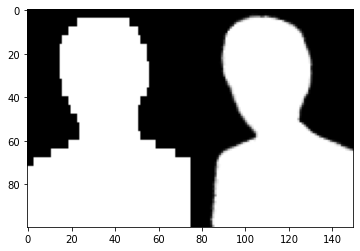

In [142]:
binary_res = (res[0]>0.5).astype(np.float64)

plt.imshow(np.concatenate([binary_res, test_mattes[0]]).reshape(2,-1,75, 1).transpose([1,0,2,3]).reshape((100,-1)), cmap='gray' )
plt.show()

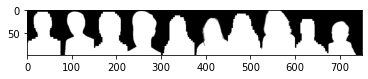

In [93]:
five = (model.predict(test_images[:5]) > 0.5).astype(np.float64)
plt.imshow(np.concatenate([five, test_mattes[0:5]], axis=2).transpose([1,0,2,3]).reshape((100,-1)), cmap='gray' )
plt.show()

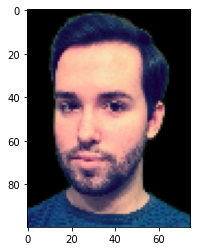

In [121]:
# 배경에 합쳐서 테스트해보기
# test 데이터
plt.imshow(test_mattes[1] * test_images[1])
plt.show()

In [143]:
five[1].shape

(100, 75, 1)

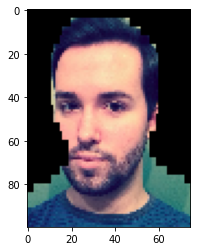

In [144]:
# 모델로 예측한 데이터
plt.imshow(five[1]* test_images[1])
plt.show()  # 정확하지 않음

In [130]:
# U-net 모델링

In [147]:
# input (100, 75, 3), output (100, 75, 1)을 처리할 수 있는 모래시계 모양의 모델을 작성하세요.
from tensorflow.keras.layers  import Dense, Input, Conv2D, Conv2DTranspose, Flatten, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Dropout, Activation, concatenate, MaxPool2D

In [148]:
def conv2d_block(x, channel):
    x = Conv2D(channel, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(channel, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def unet_like():
    inputs = Input((100, 75, 3))

    c1 = conv2d_block(inputs, 16)
    p1 = MaxPool2D(2,2)(c1)
    p1 = Dropout(0.1)(p1)

    c2 = conv2d_block(p1, 32)
    p2 = MaxPool2D(2,2)(c2)
    p2 = Dropout(0.1)(p2)

    c3 = conv2d_block(p2, 64)
    p3 = MaxPool2D(2,2)(c3)
    p3 = Dropout(0.1)(p3)

    c4 = conv2d_block(p3, 128)
    p4 = MaxPool2D(2,2)(c4)
    p4 = Dropout(0.1)(p4)

    c5 = conv2d_block(p4, 256)

    u6 = Conv2DTranspose(128, 2, 2, output_padding=(0,1))(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(0.1)(u6)
    c6 = conv2d_block(u6, 128)

    u7 = Conv2DTranspose(64, 2, 2, output_padding=(1,0))(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(0.1)(u7)
    c7 = conv2d_block(u7, 64)

    u8 = Conv2DTranspose(32, 2, 2, output_padding=(0,1))(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(0.1)(u8)
    c8 = conv2d_block(u8, 32)

    u9 = Conv2DTranspose(16, 2, 2, output_padding=(0,1))(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(0.1)(u9)
    c9 = conv2d_block(u9, 16)

    outputs = Conv2D(1,(1,1), activation='sigmoid')(c9)

    model = Model(inputs, outputs)
    return model

In [149]:
# unet_like() 모델을 할당 받고 서머리를 출력하는 코드를 작성하세요.
model = unet_like()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 100, 75, 3)] 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 100, 75, 16)  448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 100, 75, 16)  64          conv2d_19[0][0]                  
__________________________________________________________________________________________________
activation (Activation)         (None, 100, 75, 16)  0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [150]:
# 만든 모델에 loss는 mse, optimizer는 adam 매트릭은 accuracy으로 설정하는 코드를 작성하세요.
model.compile(loss='mse', optimizer='adam', metrics=['acc'])

In [ ]:
# train_images 학습시키고 25 epochs을 돌리고 그 진행 사항을 hist에 저장하는 코드를 작성하세요.
hist = model.fit(train_images,train_mattes, validation_data=(test_images,test_mattes), epochs=10, verbose=1)

Train on 1700 samples, validate on 300 samples
Epoch 1/10
1700/1700 [==============================] - 167s 98ms/sample - loss: 0.1189 - acc: 0.7775 - val_loss: 0.1524 - val_acc: 0.7136
Epoch 2/10
1700/1700 [==============================] - 174s 102ms/sample - loss: 0.0625 - acc: 0.8529 - val_loss: 0.2075 - val_acc: 0.6746
Epoch 3/10
1700/1700 [==============================] - 177s 104ms/sample - loss: 0.0473 - acc: 0.8681 - val_loss: 0.4437 - val_acc: 0.4104
Epoch 4/10
1700/1700 [==============================] - 182s 107ms/sample - loss: 0.0401 - acc: 0.8746 - val_loss: 0.1018 - val_acc: 0.7936
Epoch 5/10
 736/1700 [===========>..................] - ETA: 1:37 - loss: 0.0346 - acc: 0.8792

In [ ]:
# hist의 accuracy plt의 plot을 이용하여 출력하는 코드를 작성하세요.
plt.plot(hist.history['acc'], label='acc')
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_acc'], label='val_acc')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.legend(loc='upper right')
plt.show()

In [ ]:
# 모델에 test_mages 중 1장을 넣고 결과를 받는 코드를 작성하세요.
res = model.predict( test_images[1:2])

In [ ]:
# test_mattes[1]를 width 방향으로 결합하여 (100, 75 * 3, 1) 의 이미지를 만들어 plt로 출력하는 코드를 작성하세요.
plt.imshow(np.concatenate([res[0], test_mattes[1]]).reshape(2,-1,75, 1).transpose([1,0,2,3]).reshape((100,-1)), cmap='gray' )
plt.show()

In [ ]:
# res를 0.5기준으로 0,1의 값으로 이원화 시킨 뒤 문제 32처럼 출력하는 코드를 작성하세요.
binary_res = (res[0] > 0.5).astype(np.float64)

plt.imshow(np.concatenate([binary_res, test_mattes[1]]).reshape(2,-1,75, 1).transpose([1,0,2,3]).reshape((100,-1)), cmap='gray' )
plt.show()

In [ ]:
# 5장의 이미지를 모델에 넣고 결과를 32번과 같은 방식으로 비교하는 코드를 작성하세요
five = (model.predict( test_images[:5]) > 0.5).astype(np.float64) 

plt.imshow(np.concatenate([five, test_mattes[0:5]], axis=2).transpose([1,0,2,3]).reshape((100,-1)), cmap='gray' )
plt.show()

In [ ]:
# 예측 이미지와 원본이미지를 곱하여 배경을 지워보세요
plt.imshow( five[1].reshape((100, 75, 1)) * test_images[1])
plt.show()